# Protein Score Validation

This notebook validates the KSS Protein Score component by comparing it with UniProt annotation scores. The analysis evaluates whether KSS scores correlate with expert-curated protein characterization levels.

**Author:** KSS Project  
**Date:** 2025-01-19

## 1. Imports and Configuration

In [73]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

# Add src to path for main application modules
sys.path.append('../src')
from protein_score import calculate_protein_score

## 2. Configuration Parameters

In [74]:
# Paths
UNIPROT_DIR = "uniprot_viral_proteins"
OUTPUT_DIR = "protein_score_validation_results"

# Analysis parameters
DISCORDANCE_THRESHOLD = 0.30  # Absolute difference threshold
N_EXTREME_EXAMPLES = 20       # Number of extreme cases to report

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 3. Load Protein Scores

In [75]:
def load_protein_scores(uniprot_dir=UNIPROT_DIR):
    """
    Load UniProt annotation scores and calculate KSS protein scores.
    
    Returns:
        tuple: (uniprot_scores, kss_scores, accessions)
    """
    if not os.path.exists(uniprot_dir):
        raise FileNotFoundError(f"Directory {uniprot_dir} does not exist!")
    
    json_files = [f for f in os.listdir(uniprot_dir) if f.endswith('.json')]
    
    uniprot_scores, kss_scores, accessions = [], [], []
    
    for filename in tqdm(json_files, desc="Loading scores"):
        filepath = os.path.join(uniprot_dir, filename)
        
        try:
            with open(filepath, 'r') as f:
                protein_data = json.load(f)
            
            uniprot_score = protein_data.get('annotationScore', None)
            accession = protein_data.get('primaryAccession', '')
            
            if uniprot_score is not None and accession:
                kss_score = calculate_protein_score(filepath, verbose=False)
                
                if kss_score is not None:
                    uniprot_scores.append(uniprot_score)
                    kss_scores.append(kss_score)
                    accessions.append(accession)
        except Exception:
            continue
    
    return np.array(uniprot_scores), np.array(kss_scores), np.array(accessions)


# Load data
print("Loading protein scores...")
uniprot_scores, kss_scores, accessions = load_protein_scores()
print(f"Successfully loaded: {len(uniprot_scores)} proteins")

# Check for missing proteins from Excel file
excel_file = "uniprotkb_taxonomy_id_10239_AND_reviewed_2025_11_20.xlsx"
if os.path.exists(excel_file):
    print(f"\nChecking for missing proteins in {excel_file}...")
    df_excel = pd.read_excel(excel_file)
    
    # Get list of accessions from Excel
    if 'Entry' in df_excel.columns:
        excel_accessions = set(df_excel['Entry'].tolist())
    elif 'Accession' in df_excel.columns:
        excel_accessions = set(df_excel['Accession'].tolist())
    else:
        print("Warning: Could not find 'Entry' or 'Accession' column in Excel file")
        excel_accessions = set()
    
    # Compare with loaded accessions
    loaded_accessions = set(accessions)
    missing_accessions = excel_accessions - loaded_accessions
    
    if missing_accessions:
        print(f"⚠️  Found {len(missing_accessions)} proteins in Excel not in local dataset")
        print(f"   Consider downloading these proteins from UniProt")
        print(f"   Missing accessions (first 10): {list(missing_accessions)[:10]}")
    else:
        print(f"✓ All proteins from Excel ({len(excel_accessions)}) are present in local dataset")
else:
    print(f"\n⚠️  Excel file not found: {excel_file}")

Loading protein scores...


Loading scores:   0%|          | 0/17471 [00:00<?, ?it/s]

Loading scores: 100%|██████████| 17471/17471 [00:05<00:00, 3440.35it/s]


Successfully loaded: 17470 proteins

Checking for missing proteins in uniprotkb_taxonomy_id_10239_AND_reviewed_2025_11_20.xlsx...
⚠️  Found 15 proteins in Excel not in local dataset
   Consider downloading these proteins from UniProt
   Missing accessions (first 10): ['Q716G6', 'Q5EP34', 'C3W5S0', 'C0JJ97', 'Q9AYZ3', 'Q9MCT1', 'P0DXO4', 'C0JJA4', 'Q9MBY2', 'Q65228']


## 4. Descriptive Statistics

In [76]:
# KSS score statistics
print("KSS Score Statistics")
print("="*50)
print(f"Mean ± SD: {np.mean(kss_scores):.3f} ± {np.std(kss_scores, ddof=1):.3f}")
print(f"Median: {np.median(kss_scores):.3f}")
print(f"Range: [{np.min(kss_scores):.3f} - {np.max(kss_scores):.3f}]")

# UniProt category distribution
print("\nUniProt Annotation Score Distribution")
print("="*50)
unique, counts = np.unique(uniprot_scores, return_counts=True)
for score, count in zip(unique, counts):
    pct = (count / len(uniprot_scores)) * 100
    print(f"Score {score}: {count:4d} proteins ({pct:5.1f}%)")

KSS Score Statistics
Mean ± SD: 0.313 ± 0.217
Median: 0.300
Range: [0.000 - 1.000]

UniProt Annotation Score Distribution
Score 1.0: 4387 proteins ( 25.1%)
Score 2.0: 4937 proteins ( 28.3%)
Score 3.0: 4121 proteins ( 23.6%)
Score 4.0: 2140 proteins ( 12.2%)
Score 5.0: 1885 proteins ( 10.8%)


## 5. Correlation Analysis

In [77]:
def calculate_correlations(uniprot_scores, kss_scores):
    """
    Calculate Spearman and Kendall correlations with 95% CI.
    
    Returns:
        dict: Correlation results with confidence intervals
    """
    n = len(uniprot_scores)
    
    # Spearman correlation
    spearman_corr, spearman_p = stats.spearmanr(uniprot_scores, kss_scores)
    
    # Fisher z-transformation for CI
    z_spearman = 0.5 * np.log((1 + spearman_corr) / (1 - spearman_corr))
    se_z = 1 / np.sqrt(n - 3)
    z_lower = z_spearman - 1.96 * se_z
    z_upper = z_spearman + 1.96 * se_z
    ci_lower_s = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    ci_upper_s = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)
    
    # Kendall correlation
    kendall_corr, kendall_p = stats.kendalltau(uniprot_scores, kss_scores)
    
    # Approximate CI for Kendall
    se_kendall = np.sqrt(2 * (2 * n + 5) / (9 * n * (n - 1)))
    ci_lower_k = max(-1, kendall_corr - 1.96 * se_kendall)
    ci_upper_k = min(1, kendall_corr + 1.96 * se_kendall)
    
    return {
        'n_samples': n,
        'spearman': {
            'correlation': spearman_corr,
            'p_value': spearman_p,
            'ci_95': (ci_lower_s, ci_upper_s)
        },
        'kendall': {
            'correlation': kendall_corr,
            'p_value': kendall_p,
            'ci_95': (ci_lower_k, ci_upper_k)
        }
    }


# Calculate correlations
correlation_results = calculate_correlations(uniprot_scores, kss_scores)

print("\nCorrelation Analysis")
print("="*50)
print(f"Dataset size: {correlation_results['n_samples']:,} proteins")

spearman = correlation_results['spearman']
print(f"\nSpearman ρ = {spearman['correlation']:.4f}")
print(f"  95% CI: [{spearman['ci_95'][0]:.3f}, {spearman['ci_95'][1]:.3f}]")
print(f"  p-value: {spearman['p_value']:.2e}")

kendall = correlation_results['kendall']
print(f"\nKendall τ = {kendall['correlation']:.4f}")
print(f"  95% CI: [{kendall['ci_95'][0]:.3f}, {kendall['ci_95'][1]:.3f}]")
print(f"  p-value: {kendall['p_value']:.2e}")


Correlation Analysis
Dataset size: 17,470 proteins

Spearman ρ = 0.9000
  95% CI: [0.897, 0.903]
  p-value: 0.00e+00

Kendall τ = 0.7765
  95% CI: [0.767, 0.786]
  p-value: 0.00e+00


## 6. Granularity Analysis

In [78]:
def analyze_granularity(uniprot_scores, kss_scores):
    """
    Analyze KSS score distribution within UniProt categories.
    
    Returns:
        dict: Statistics by category and Kruskal-Wallis test results
    """
    df = pd.DataFrame({
        'UniProt_Category': uniprot_scores,
        'KSS_Score': kss_scores
    })
    
    # Statistics by category
    stats_by_category = df.groupby('UniProt_Category')['KSS_Score'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(4)
    
    # Coefficient of variation
    stats_by_category['CV(%)'] = (
        stats_by_category['std'] / stats_by_category['mean'] * 100
    ).round(2)
    
    # Kruskal-Wallis test (non-parametric ANOVA)
    kss_by_category = [
        df[df['UniProt_Category'] == cat]['KSS_Score'].values
        for cat in sorted(df['UniProt_Category'].unique())
    ]
    h_stat, p_value = stats.kruskal(*kss_by_category)
    
    return {
        'stats_by_category': stats_by_category,
        'kruskal_wallis': {'h_statistic': h_stat, 'p_value': p_value}
    }


# Analyze granularity
granularity_results = analyze_granularity(uniprot_scores, kss_scores)

print("\nGranularity Analysis")
print("="*50)
print("\nKSS Score Statistics by UniProt Category:")
display(granularity_results['stats_by_category'])

kw = granularity_results['kruskal_wallis']
print(f"\nKruskal-Wallis Test:")
print(f"  H-statistic = {kw['h_statistic']:.2f}")
print(f"  p-value = {kw['p_value']:.2e}")


Granularity Analysis

KSS Score Statistics by UniProt Category:


,count,mean,std,min,max,CV(%)
UniProt_Category,,,,,,
1.0,4387,0.0660,0.0621,0.00,0.42,94.09
2.0,4937,0.2361,0.0925,0.00,0.62,39.18
3.0,4121,0.4089,0.1087,0.05,0.80,26.58
4.0,2140,0.5025,0.1044,0.17,0.94,20.78
5.0,1885,0.6678,0.1476,0.07,1.00,22.10



Kruskal-Wallis Test:
  H-statistic = 14197.59
  p-value = 0.00e+00


## 7. Discordance Analysis

In [79]:
def enrich_discordant_proteins(accessions_list, uniprot_dir=UNIPROT_DIR):
    """
    Enrich discordant proteins with detailed UniProt metadata and KSS criteria.
    
    Args:
        accessions_list: List of protein accessions
        uniprot_dir: Directory containing UniProt JSON files
    
    Returns:
        DataFrame: Enriched protein information
    """
    enriched_data = []
    
    for accession in tqdm(accessions_list, desc="Enriching proteins"):
        filepath = os.path.join(uniprot_dir, f"{accession}.json")
        
        if not os.path.exists(filepath):
            continue
        
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
            
            # Basic information
            protein_name = "N/A"
            if 'proteinDescription' in data:
                if 'recommendedName' in data['proteinDescription']:
                    protein_name = data['proteinDescription']['recommendedName']['fullName']['value']
                elif 'submittedName' in data['proteinDescription']:
                    protein_name = data['proteinDescription']['submittedName'][0]['fullName']['value']
            
            organism = data.get('organism', {}).get('scientificName', 'N/A')
            protein_existence = data.get('proteinExistence', 'Unknown')
            num_references = len(data.get('references', []))
            
            # Count GO terms
            go_mf, go_bp, go_cc = 0, 0, 0
            has_3d_structure = False
            has_ptm = False
            has_interactions = False
            
            if 'uniProtKBCrossReferences' in data:
                for xref in data['uniProtKBCrossReferences']:
                    db = xref.get('database', '')
                    
                    # GO terms
                    if db == 'GO':
                        for prop in xref.get('properties', []):
                            if prop.get('key') == 'GoTerm':
                                term = prop.get('value', '')
                                if term.startswith('F:'):
                                    go_mf += 1
                                elif term.startswith('P:'):
                                    go_bp += 1
                                elif term.startswith('C:'):
                                    go_cc += 1
                    
                    # 3D structure
                    if db == 'PDB':
                        has_3d_structure = True
                    
                    # Protein interactions
                    if db in ['IntAct', 'BioGRID', 'STRING', 'ComplexPortal']:
                        has_interactions = True
            
            # PTM
            if 'keywords' in data:
                for keyword in data['keywords']:
                    if keyword.get('category', '') == 'PTM':
                        has_ptm = True
                        break
            
            # Count functional features
            num_features = 0
            if 'features' in data:
                target_types = {
                    'domain', 'active_site', 'binding_site', 'site',
                    'transmembrane', 'topological_domain', 'region', 'motif'
                }
                for feature in data['features']:
                    if feature.get('type', '').lower().replace(' ', '_') in target_types:
                        num_features += 1
            
            enriched_data.append({
                'Accession': accession,
                'Protein_Name': protein_name,
                'Organism': organism,
                'Protein_Existence': protein_existence.split(':')[0] if ':' in protein_existence else protein_existence,
                'Num_References': num_references,
                'GO_MF': go_mf,
                'GO_BP': go_bp,
                'GO_CC': go_cc,
                'Has_3D_Structure': 'Yes' if has_3d_structure else 'No',
                'Has_PTM': 'Yes' if has_ptm else 'No',
                'Has_Interactions': 'Yes' if has_interactions else 'No',
                'Num_Structural_Functional_Features': num_features
            })
        
        except Exception as e:
            continue
    
    return pd.DataFrame(enriched_data)


def identify_and_enrich_discordances(uniprot_scores, kss_scores, accessions,
                                      threshold=DISCORDANCE_THRESHOLD,
                                      n_examples=N_EXTREME_EXAMPLES,
                                      uniprot_dir=UNIPROT_DIR):
    """
    Identify proteins with substantial score discordance and enrich with metadata.
    
    Args:
        uniprot_scores: UniProt annotation scores (1-5)
        kss_scores: KSS protein scores (0-1)
        accessions: Protein accessions
        threshold: Absolute difference threshold
        n_examples: Number of extreme examples per direction
        uniprot_dir: Directory containing UniProt JSON files
    
    Returns:
        dict: Discordance statistics and enriched extreme examples
    """
    # Normalize UniProt scores to [0,1]
    uniprot_normalized = (uniprot_scores - 1) / 4.0
    
    # Calculate delta (KSS - UniProt)
    delta = kss_scores - uniprot_normalized
    
    df = pd.DataFrame({
        'Accession': accessions,
        'UniProt_Annotation_Score': uniprot_scores,
        'UniProt_Normalized_Score': uniprot_normalized,
        'KSS_Score': kss_scores,
        'Δ (KSS - UniProt_norm)': delta
    })
    
    # Identify high discordance
    positive_discordance = df[df['Δ (KSS - UniProt_norm)'] > threshold]
    negative_discordance = df[df['Δ (KSS - UniProt_norm)'] < -threshold]
    
    # Get extreme examples
    extreme_positive = positive_discordance.nlargest(n_examples, 'Δ (KSS - UniProt_norm)')
    extreme_negative = negative_discordance.nsmallest(n_examples, 'Δ (KSS - UniProt_norm)')
    
    # Enrich with metadata
    print("\nEnriching positive discordance cases...")
    positive_enriched = enrich_discordant_proteins(extreme_positive['Accession'].tolist(), uniprot_dir)
    extreme_positive_full = extreme_positive.merge(positive_enriched, on='Accession', how='left')
    
    print("Enriching negative discordance cases...")
    negative_enriched = enrich_discordant_proteins(extreme_negative['Accession'].tolist(), uniprot_dir)
    extreme_negative_full = extreme_negative.merge(negative_enriched, on='Accession', how='left')
    
    return {
        'threshold': threshold,
        'n_total': len(df),
        'n_positive': len(positive_discordance),
        'pct_positive': (len(positive_discordance) / len(df)) * 100,
        'n_negative': len(negative_discordance),
        'pct_negative': (len(negative_discordance) / len(df)) * 100,
        'extreme_positive_enriched': extreme_positive_full,
        'extreme_negative_enriched': extreme_negative_full,
        'all_data': df
    }


# Identify and enrich discordances
print("\nDiscordance Analysis")
print("="*50)
discordance_results = identify_and_enrich_discordances(
    uniprot_scores, kss_scores, accessions
)

print(f"Threshold: |Δ| > {discordance_results['threshold']}")
print(f"  where Δ = KSS_score - UniProt_normalized")

print(f"\nPositive discordance (KSS > UniProt):")
print(f"  {discordance_results['n_positive']} proteins ({discordance_results['pct_positive']:.1f}%)")

print(f"\nNegative discordance (KSS < UniProt):")
print(f"  {discordance_results['n_negative']} proteins ({discordance_results['pct_negative']:.1f}%)")

# Display enriched tables
print(f"\nTop {N_EXTREME_EXAMPLES} Positive Discordance (High KSS relative to UniProt):")
display(discordance_results['extreme_positive_enriched'][[
    'Accession', 'Protein_Name', 'Organism', 
    'UniProt_Annotation_Score', 'UniProt_Normalized_Score', 'KSS_Score', 
    'Δ (KSS - UniProt_norm)', 'Protein_Existence', 'Num_References', 
    'GO_MF', 'GO_BP', 'GO_CC', 'Has_3D_Structure', 'Has_PTM', 
    'Has_Interactions', 'Num_Structural_Functional_Features'
]])

print(f"\nTop {N_EXTREME_EXAMPLES} Negative Discordance (Low KSS relative to UniProt):")
display(discordance_results['extreme_negative_enriched'][[
    'Accession', 'Protein_Name', 'Organism',
    'UniProt_Annotation_Score', 'UniProt_Normalized_Score', 'KSS_Score',
    'Δ (KSS - UniProt_norm)', 'Protein_Existence', 'Num_References',
    'GO_MF', 'GO_BP', 'GO_CC', 'Has_3D_Structure', 'Has_PTM',
    'Has_Interactions', 'Num_Structural_Functional_Features'
]])

# Save enriched tables
pos_enriched_file = os.path.join(OUTPUT_DIR, 'positive_discordance_top20_enriched.csv')
discordance_results['extreme_positive_enriched'].to_csv(pos_enriched_file, index=False)
print(f"\nPositive discordance enriched table saved to: {pos_enriched_file}")

neg_enriched_file = os.path.join(OUTPUT_DIR, 'negative_discordance_top20_enriched.csv')
discordance_results['extreme_negative_enriched'].to_csv(neg_enriched_file, index=False)
print(f"Negative discordance enriched table saved to: {neg_enriched_file}")


Discordance Analysis

Enriching positive discordance cases...


Enriching proteins: 100%|██████████| 20/20 [00:00<00:00, 5000.36it/s]


Enriching negative discordance cases...


Enriching proteins: 100%|██████████| 20/20 [00:00<00:00, 3330.93it/s]

Threshold: |Δ| > 0.3
  where Δ = KSS_score - UniProt_normalized

Positive discordance (KSS > UniProt):
  23 proteins (0.1%)

Negative discordance (KSS < UniProt):
  1783 proteins (10.2%)

Top 20 Positive Discordance (High KSS relative to UniProt):


,Accession,Protein_Name,Organism,UniProt_Annotation_Score,UniProt_Normalized_Score,KSS_Score,Δ (KSS - UniProt_norm),Protein_Existence,Num_References,GO_MF,GO_BP,GO_CC,Has_3D_Structure,Has_PTM,Has_Interactions,Num_Structural_Functional_Features
0,P16751,Uncharacterized protein UL78,Human cytomegalovirus (strain AD169),1.0,0.00,0.42,0.42,1,3,0,0,1,Yes,Yes,No,7
1,P42484,DNA-directed RNA polymerase RPB6 homolog,African swine fever virus (strain Badajoz 1971...,2.0,0.25,0.62,0.37,1,5,4,2,3,Yes,No,No,0
2,P34081,DNA endonuclease I-HmuI,Bacillus phage SP01,1.0,0.00,0.35,0.35,1,2,1,1,0,Yes,No,No,0
3,P90463,Thymidylate synthase,Human herpesvirus 8 type P (isolate GK18),2.0,0.25,0.60,0.35,1,3,1,3,0,Yes,No,Yes,8
4,Q5UPL1,Uncharacterized protein L136,Acanthamoeba polyphaga mimivirus,1.0,0.00,0.35,0.35,1,1,2,1,0,Yes,No,No,0
5,P04132,Repressor protein C,Escherichia phage P2,1.0,0.00,0.33,0.33,1,3,1,0,0,Yes,No,No,1
6,A7J3A1,Intermediate capsid protein VP6,Rotavirus A (strain RVA/Cow/United States/NCDV...,2.0,0.25,0.58,0.33,1,3,3,1,2,Yes,Yes,No,4
7,P42488,DNA-directed RNA polymerase RPB10 homolog,African swine fever virus (strain Badajoz 1971...,2.0,0.25,0.58,0.33,1,3,3,2,2,Yes,No,No,4
8,P17574,Coat protein,Satellite tobacco mosaic virus,1.0,0.00,0.32,0.32,1,2,1,0,1,Yes,No,No,0
9,Q5UNW3,Uncharacterized protein R705,Acanthamoeba polyphaga mimivirus,1.0,0.00,0.32,0.32,1,2,0,0,1,No,No,No,1



Top 20 Negative Discordance (Low KSS relative to UniProt):


,Accession,Protein_Name,Organism,UniProt_Annotation_Score,UniProt_Normalized_Score,KSS_Score,Δ (KSS - UniProt_norm),Protein_Existence,Num_References,GO_MF,GO_BP,GO_CC,Has_3D_Structure,Has_PTM,Has_Interactions,Num_Structural_Functional_Features
0,Q8QL26,Uncharacterized protein 1070,Sulfolobus islandicus rod-shaped virus 1,5.0,1.0,0.07,-0.93,4,2,0,0,0,No,No,No,1
1,Q9J3N8,Membrane protein,Avian infectious bronchitis virus (strain DE072),5.0,1.0,0.30,-0.70,3,1,1,0,4,No,Yes,No,7
2,P0C8F2,Serine/threonine-protein kinase 1,African swine fever virus (isolate Tick/South ...,5.0,1.0,0.34,-0.66,3,1,21,0,2,No,No,No,4
3,P0C8F3,Serine/threonine-protein kinase 1,African swine fever virus (isolate Warthog/Nam...,5.0,1.0,0.34,-0.66,3,1,21,0,2,No,No,No,4
4,P0C8F4,Serine/threonine-protein kinase 1,African swine fever virus (isolate Pig/Kenya/K...,5.0,1.0,0.34,-0.66,3,1,21,0,2,No,No,No,4
5,P39423,NAD--protein ADP-ribosyltransferase modB,Enterobacteria phage T4,5.0,1.0,0.34,-0.66,1,7,1,0,1,No,No,No,2
6,P28995,Glycoprotein 5,Equine arteritis virus (strain Bucyrus),5.0,1.0,0.35,-0.65,1,2,0,0,3,No,Yes,No,3
7,O92446,Capsid-associated protein Vp91,Bombyx mori nuclear polyhedrosis virus,5.0,1.0,0.36,-0.64,3,2,2,0,2,No,Yes,No,3
8,Q03396,RNA-directed RNA polymerase L,Parainfluenza virus 5 (strain 21004-WR),5.0,1.0,0.36,-0.64,3,1,4,0,2,No,No,No,4
9,Q6UDH7,Serine/threonine-protein kinase UL13,Psittacid herpesvirus 1 (isolate Amazon parrot...,5.0,1.0,0.36,-0.64,3,1,21,0,2,No,No,No,5



Positive discordance enriched table saved to: protein_score_validation_results\positive_discordance_top20_enriched.csv
Negative discordance enriched table saved to: protein_score_validation_results\negative_discordance_top20_enriched.csv


## 8. Visualizations


Figure saved to: protein_score_validation_results\protein_score_validation.pdf


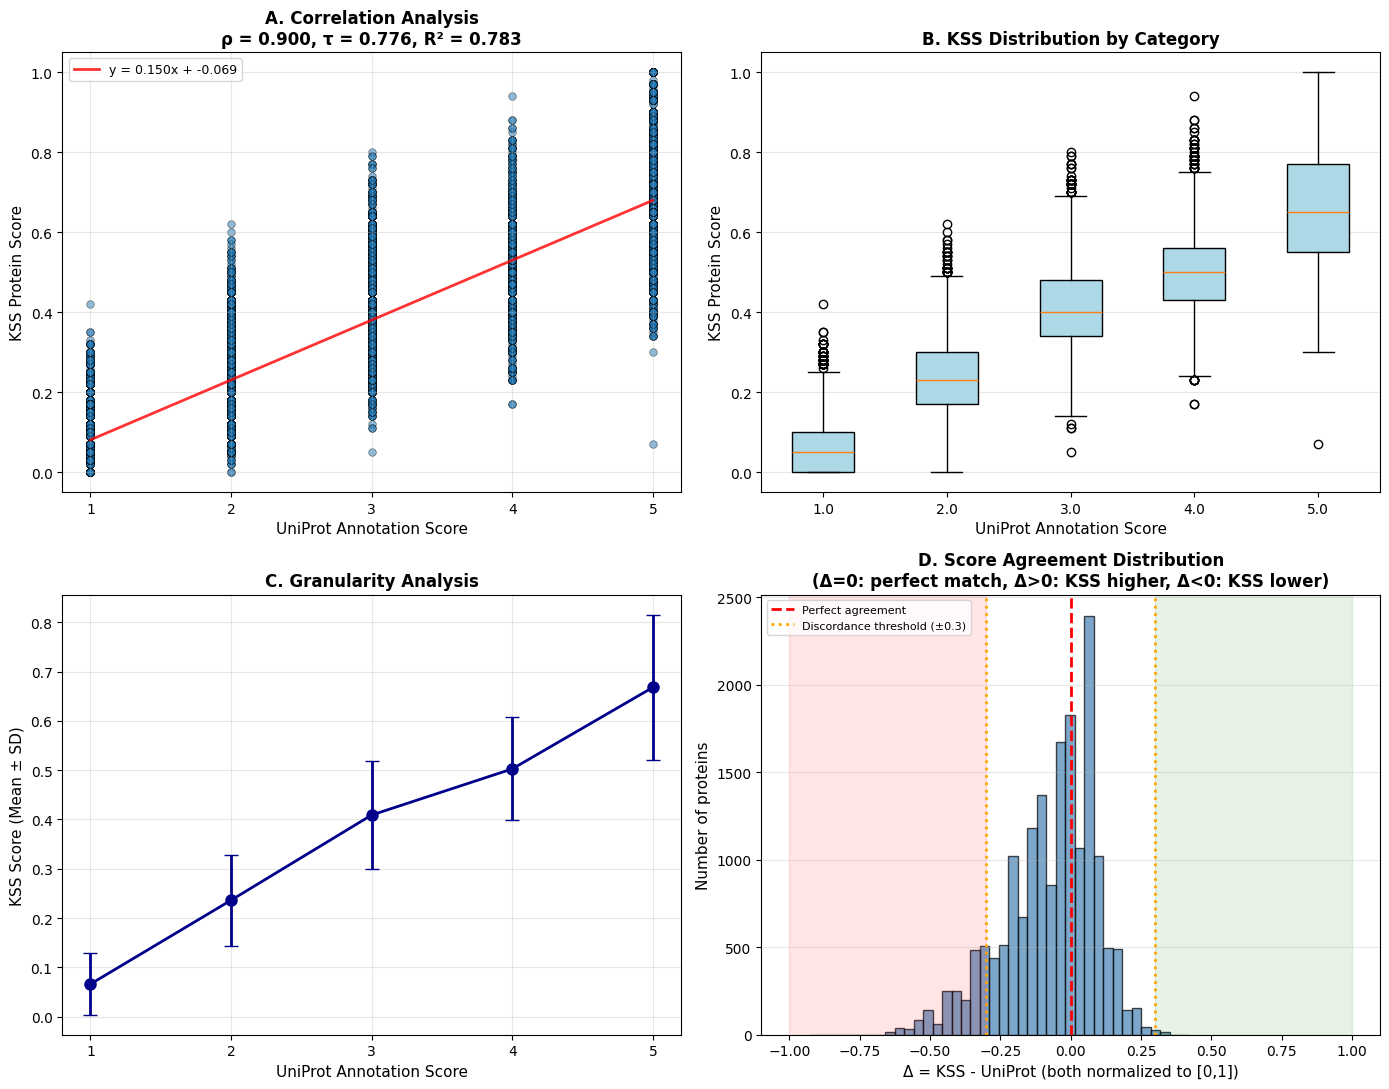

In [80]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 11))

# A. Scatter plot with correlation and regression line
ax1.scatter(uniprot_scores, kss_scores, alpha=0.5, s=30, edgecolors='black', linewidths=0.5)

# Calculate and plot linear regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(uniprot_scores, kss_scores)
x_line = np.array([1, 5])
y_line = slope * x_line + intercept
ax1.plot(x_line, y_line, 'r-', linewidth=2, alpha=0.8, 
         label=f'y = {slope:.3f}x + {intercept:.3f}')

ax1.set_xlabel('UniProt Annotation Score', fontsize=11)
ax1.set_ylabel('KSS Protein Score', fontsize=11)
spearman_r = correlation_results['spearman']['correlation']
kendall_tau = correlation_results['kendall']['correlation']
ax1.set_title(f'A. Correlation Analysis\nρ = {spearman_r:.3f}, τ = {kendall_tau:.3f}, R² = {r_value**2:.3f}',
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xticks([1, 2, 3, 4, 5])

# B. Boxplot by UniProt category
df_plot = pd.DataFrame({'UniProt': uniprot_scores, 'KSS': kss_scores})
categories = sorted(df_plot['UniProt'].unique())
kss_by_cat = [df_plot[df_plot['UniProt'] == cat]['KSS'].values for cat in categories]

bp = ax2.boxplot(kss_by_cat, tick_labels=categories, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax2.set_xlabel('UniProt Annotation Score', fontsize=11)
ax2.set_ylabel('KSS Protein Score', fontsize=11)
ax2.set_title('B. KSS Distribution by Category', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# C. Granularity: Mean ± SD
stats = granularity_results['stats_by_category']
ax3.errorbar(stats.index, stats['mean'], yerr=stats['std'],
             fmt='o-', capsize=5, markersize=8, linewidth=2, color='darkblue')
ax3.set_xlabel('UniProt Annotation Score', fontsize=11)
ax3.set_ylabel('KSS Score (Mean ± SD)', fontsize=11)
ax3.set_title('C. Granularity Analysis', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(stats.index)

# D. Agreement/Discordance Distribution
uniprot_norm = (uniprot_scores - 1) / 4.0
differences = kss_scores - uniprot_norm

ax4.hist(differences, bins=40, alpha=0.7, edgecolor='black', color='steelblue')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Perfect agreement')
ax4.axvline(x=DISCORDANCE_THRESHOLD, color='orange', linestyle=':', linewidth=2,
            label=f'Discordance threshold (±{DISCORDANCE_THRESHOLD})')
ax4.axvline(x=-DISCORDANCE_THRESHOLD, color='orange', linestyle=':', linewidth=2)

# Add shaded regions
ax4.axvspan(-1, -DISCORDANCE_THRESHOLD, alpha=0.1, color='red')
ax4.axvspan(DISCORDANCE_THRESHOLD, 1, alpha=0.1, color='green')

ax4.set_xlabel('Δ = KSS - UniProt (both normalized to [0,1])', fontsize=11)
ax4.set_ylabel('Number of proteins', fontsize=11)
ax4.set_title('D. Score Agreement Distribution\n(Δ=0: perfect match, Δ>0: KSS higher, Δ<0: KSS lower)',
              fontsize=12, fontweight='bold')
ax4.legend(fontsize=8, loc='upper left')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig_path = os.path.join(OUTPUT_DIR, 'protein_score_validation.pdf')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to: {fig_path}")
plt.show()

## 9. Export Results

In [81]:
# Save correlation results
correlation_summary = pd.DataFrame([
    {
        'Metric': 'Spearman ρ',
        'Value': correlation_results['spearman']['correlation'],
        'CI_Lower': correlation_results['spearman']['ci_95'][0],
        'CI_Upper': correlation_results['spearman']['ci_95'][1],
        'p_value': correlation_results['spearman']['p_value']
    },
    {
        'Metric': 'Kendall τ',
        'Value': correlation_results['kendall']['correlation'],
        'CI_Lower': correlation_results['kendall']['ci_95'][0],
        'CI_Upper': correlation_results['kendall']['ci_95'][1],
        'p_value': correlation_results['kendall']['p_value']
    }
])
corr_file = os.path.join(OUTPUT_DIR, 'correlation_results.csv')
correlation_summary.to_csv(corr_file, index=False)
print(f"Correlation results saved to: {corr_file}")

# Save granularity analysis
gran_file = os.path.join(OUTPUT_DIR, 'granularity_by_category.csv')
granularity_results['stats_by_category'].to_csv(gran_file)
print(f"Granularity results saved to: {gran_file}")

# Save complete dataset
all_file = os.path.join(OUTPUT_DIR, 'complete_protein_scores.csv')
discordance_results['all_data'].to_csv(all_file, index=False)
print(f"Complete dataset saved to: {all_file}")

# Note: Enriched discordance tables are already saved in block 7

Correlation results saved to: protein_score_validation_results\correlation_results.csv
Granularity results saved to: protein_score_validation_results\granularity_by_category.csv
Complete dataset saved to: protein_score_validation_results\complete_protein_scores.csv


## 10. Summary

In [82]:
print("\n" + "="*60)
print("VALIDATION SUMMARY")
print("="*60)

print(f"\nDataset:")
print(f"  Total proteins analyzed: {correlation_results['n_samples']:,}")
print(f"  KSS score range: [{np.min(kss_scores):.3f}, {np.max(kss_scores):.3f}]")

print(f"\nCorrelation with UniProt annotation:")
print(f"  Spearman ρ = {spearman['correlation']:.4f} (p < 0.001)")
print(f"  Kendall τ = {kendall['correlation']:.4f} (p < 0.001)")

print(f"\nGranularity:")
print(f"  Kruskal-Wallis H = {kw['h_statistic']:.2f} (p < 0.001)")
print(f"  Significant discrimination between categories: Yes")

print(f"\nDiscordance (threshold = {DISCORDANCE_THRESHOLD}):")
print(f"  High KSS vs UniProt: {discordance_results['pct_positive']:.1f}%")
print(f"  Low KSS vs UniProt: {discordance_results['pct_negative']:.1f}%")

print("\n" + "="*60)
print("CONCLUSION: KSS Protein Score validated successfully")
print("="*60)


VALIDATION SUMMARY

Dataset:
  Total proteins analyzed: 17,470
  KSS score range: [0.000, 1.000]

Correlation with UniProt annotation:
  Spearman ρ = 0.9000 (p < 0.001)
  Kendall τ = 0.7765 (p < 0.001)

Granularity:
  Kruskal-Wallis H = 14197.59 (p < 0.001)
  Significant discrimination between categories: Yes

Discordance (threshold = 0.3):
  High KSS vs UniProt: 0.1%
  Low KSS vs UniProt: 10.2%

CONCLUSION: KSS Protein Score validated successfully
